# Lab 3 Image data

## Objectives

* Learn to manipulate image data using the Images package
* Understand the SOM algorithm and its implementation
* Apply clustering algorithms to image segmentation

## Colour mapping using SOM

As usual, import some important stuff first (install missing packages if needed):

In [1]:
# import Pkg; Pkg.add("Images")
# import Pkg; Pkg.add("ImageIO")

In [2]:
using Images, ImageIO, Plots, Random

We start with some impressionist graffiti, generating a 50x50 image with random RGB values assigned to its pixels: 

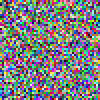

In [3]:
Random.seed!(0)
randimg = rand(RGB{Float64}, 50, 50)

The picture looks quite messy. Our plan is to learn a "palette" from the random colour pixels, and we surely want an organized palette. To this end we will employ the SOM algorithm, whose self-organizing capability may help map out similar colors onto neighbourhood on a 2D grid.

First of all, we prepare the RGB pixels into a data array formed by 3-D vectors (each column now represents a pixel) - this is the data matrix for us to cluster. 

In [4]:
X = Array(reshape(channelview(randimg), 3, :))  # reshape image; each column contains RGB of a pixel

3×2500 Matrix{Float64}:
 0.823648  0.177329  0.0423017  0.973216  …  0.779879  0.930664  0.917317
 0.910357  0.27888   0.0682693  0.585812     0.495239  0.468646  0.27101
 0.164566  0.203477  0.361828   0.539289     0.380293  0.136405  0.194625

The key idea of SOM is to have weight vectors organized onto a 2-D grid. We need two dimensions for the grid location (x and y), and another dimension to store the relevant weight vector with RGB values. Hence we initialize a 3-D weight array (returned as "W") with random values:

In [5]:
# randomly init SOM weight vectors by copying random input vectors
function initWeights(mapw::Int, maph::Int, dim::Int)
    W = rand(dim, maph, mapw)
    return W
end

initWeights (generic function with 1 method)

We define two more functions for SOM learning. First for finding the best matching unit (BMU) on the grid given an input vector x, which returns : 

In [6]:
function findBMU(x::Vector{Float64}, Weights::Array{Float64, 3})
    D = Weights .- x
    norms2 = sum(abs2, D, dims=1)  # sqrt() is skipped because it is not necessary
    spot = argmin(norms2)
    gridy, gridx = spot[2], spot[3]
end

findBMU (generic function with 1 method)

And then for updating the nodes within the neighbourhood of the BMU: 

In [7]:
function updateNodes!(Weights::Array{Float64, 3}, x::Vector{Float64}, i::Int64, j::Int64, nei::Int64, γ::Float64)
    dim, maph, mapw= size(Weights)
    up = max(1, i-nei)
    down = min(maph, i+nei)
    left = max(1, j-nei)
    right = min(mapw, j+nei)
    Weights[:, up:down, left:right] .+=  γ*(x .- Weights[:, up:down, left:right])
end

updateNodes! (generic function with 1 method)

Finally, let's have a function for training that scans through the dataset, updates the weights while adapting the neighbourhood size and the learning rate:

In [8]:
function train_som!(Weights::Array{Float64, 3}, X::Matrix{Float64}, niters::Int64, γ::Float64, neigh::Int64)
    dim, nd = size(X)
    for t in 1:niters
        # sequential scan
        x = X[:, (t-1)%nd+1]
        gridy, gridx = findBMU(x, Weights) 
        nei = round(Int, neigh*(niters-t+1)/niters)
        updateNodes!(Weights, x, gridy, gridx, nei, γ*(niters-t+1)/niters)
    end
end

train_som! (generic function with 1 method)

Now we are ready - the main code follows:

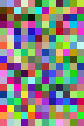

In [9]:
# Now the main code 
niters = 100000  # number of total iterations
neigh = 8      # initial neighbour radius
γ = 0.05   # initial learning rate
W = initWeights(12, 18, 3)   # init the weights and visualize it
colorview(RGB, W)

Of course our "palette" looks quite messy. Let's train it and see if makes a difference: 

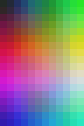

In [10]:
train_som!(W, X, niters, γ, neigh)
colorview(RGB, W)

**Task 1**. 
Question: Explain the SOM implementation given above. 
    - What neighbourhood function is used?
    - How are the neighbourhood size and the learning rate adapted over time?

- the neighbourhood function is a rectangular "bubble" centred at the BMU, i.e., within the bubble the neigbhourhood function gives 1; outside, 0.
- When iteration grows, the neighbourhood size shrinks by a ratio of (N-t)/N(N−t)/N (NN=niter). The learning rate is also scaled by (N-t)/N(N−t)/N. This is a simple strategy that works in practice, but exponential decreasing of the neighbourhood size and the learning rate is usually recommended (more aggressive at the beginning but flatter in latter stage).



**Task 2.** Write a function to return the overall average quantization of a codebook, given the data array, and the nodes array of a SOM. Test it with the random data and the learned color map. 

**Tips**: *Iterate through the data array X. Use each (column) vector as input, find out its BMU on the grid, and calculate the distance between the input and the BMU. Find the average for all inputs. Do NOT modify any weights.*

In [11]:
function vq_error(X::Array{Float64, 2}, Weights::Array{Float64, 3})
    # your code
    dim, nd = size(X)
    println("Data size:", dim, "x", nd)
    err = 0.0
    for i in 1:nd
        x = X[:, i]
        gridy, gridx = findBMU(x, Weights) 
        err += sqrt(sum(abs2, x .- Weights[:, gridy, gridx]))
    end
    return err/nd
end

vq_error (generic function with 1 method)

In [12]:
# testing code
vq_error(X, W)

Data size:3x2500


0.11012984709468056

## Image segmentation

So much for the fun. Let's put clustering into use for a serious application - image segmentation. Here we have a full-size image that can be segmented into a number of regions, so that object recognition and other computer vision tasks can be carried out. We load in an colourful picture:

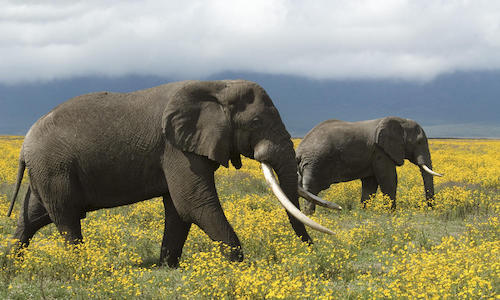

In [13]:
# Read the image into a pix array
img = load("./africa.png")

In [14]:
size(img) # get the size of the image

(300, 500)

The channelview() function allows us to look into the data structure - it is actually a 3-D array, with each column containing RGB in Float values, and a Alpha band for opaqueness (the values are all 1.0):

In [15]:
channelview(img)

4×300×500 reinterpret(reshape, N0f8, ::Array{RGBA{N0f8},2}) with eltype N0f8:
[:, :, 1] =
 0.851  0.859  0.871  0.875  0.871  …  0.549  0.49   0.569  0.463  0.435
 0.871  0.878  0.89   0.894  0.89      0.596  0.537  0.616  0.514  0.486
 0.882  0.89   0.902  0.906  0.902     0.408  0.349  0.42   0.306  0.267
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0

[:, :, 2] =
 0.851  0.859  0.871  0.875  0.871  …  0.463  0.569  0.576  0.435  0.38
 0.871  0.878  0.89   0.894  0.89      0.51   0.604  0.616  0.475  0.42
 0.882  0.89   0.902  0.906  0.902     0.314  0.42   0.42   0.271  0.212
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0

[:, :, 3] =
 0.851  0.859  0.867  0.871  0.871  …  0.412  0.478  0.49   0.459  0.498
 0.871  0.878  0.886  0.89   0.89      0.463  0.518  0.529  0.498  0.537
 0.882  0.89   0.898  0.902  0.902     0.251  0.322  0.333  0.302  0.341
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0

...

[:, :, 498

For conveniance, let's turn it into a Julia matrix of RGB vectors ;0) 

In [16]:
pixarr = Array(reshape(channelview(img), 4, :)[1:3,:])

3×150000 Array{N0f8,2} with eltype N0f8:
 0.851  0.859  0.871  0.875  0.871  …  0.965  0.969  0.949  0.761  0.549
 0.871  0.878  0.89   0.894  0.89      0.937  0.875  0.878  0.694  0.49
 0.882  0.89   0.902  0.906  0.902     0.337  0.208  0.259  0.278  0.329

We can restore the colour image from this pixel array, using reshape() and colorview():

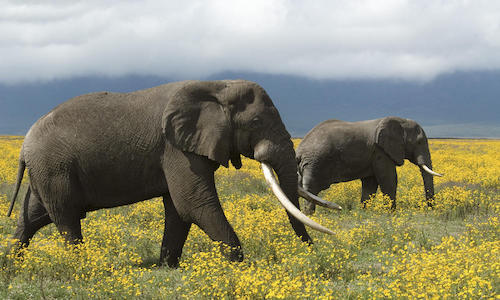

In [17]:
colorview(RGB, reshape(pixarr, 3, 300, 500))

Roughly we see four classes: sky, mountain, elephant, and grass. Let's see how a clustering operation can group the pixels into 4 categories:

In [18]:
using Clustering
km = kmeans(pixarr, 4; maxiter=20, display=:iter)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.639408e+03
      1       4.035366e+03      -2.604042e+03 |        4
      2       3.653496e+03      -3.818699e+02 |        4
      3       3.630039e+03      -2.345728e+01 |        4
      4       3.625726e+03      -4.312988e+00 |        4
      5       3.624708e+03      -1.018066e+00 |        4
      6       3.624302e+03      -4.057617e-01 |        4
      7       3.624135e+03      -1.672363e-01 |        4
      8       3.624099e+03      -3.588867e-02 |        4
      9       3.624083e+03      -1.538086e-02 |        3
     10       3.624080e+03      -3.662109e-03 |        3
     11       3.624078e+03      -1.953125e-03 |        3
     12       3.624076e+03      -1.464844e-03 |        2
     13       3.624074e+03      -2.441406e-03 |        2
     14       3.624075e+03       1.464844e-03 |        2
     15       3.624076e+03       4.882812e-04 |        

┌ Warning: The clustering cost increased at iteration #14
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #15
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #16
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191


K-means converged with 19 iterations (objv = 3624.0708)


KmeansResult{Matrix{Float32}, Float32, Int64}(Float32[0.8237035 0.2141961 0.7432185 0.4782179; 0.84705275 0.19746633 0.672635 0.48941943; 0.86874557 0.14661372 0.29718342 0.4179899], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 4, 4, 4, 3, 3, 3, 3, 4], Float32[0.0035895861, 0.0029702962, 0.0020408845, 0.0056523313, 0.0020408845, 0.006272098, 0.0020408845, 0.0020408845, 0.008644489, 0.008644489  …  0.06039806, 0.04484662, 0.032474067, 0.031936675, 0.06676594, 0.11940967, 0.098437116, 0.088084444, 0.0041819895, 0.013613084], [38346, 33081, 27002, 51571], [38346, 33081, 27002, 51571], 3624.0708f0, 19, true)

Check out the centres:

In [19]:
m = km.centers 

3×4 Matrix{Float32}:
 0.823704  0.214196  0.743218  0.478218
 0.847053  0.197466  0.672635  0.489419
 0.868746  0.146614  0.297183  0.41799

Now we can visualize the assignment of the pixels. Here's a try using heatmap: 

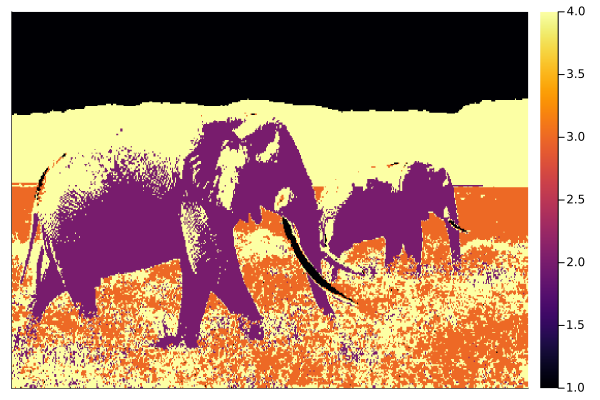

In [20]:
a = assignments(km) # get the assignments of points to clusters
heatmap(reshape(a, (300, 500)), yflip=true, axis=nothing)

**Task 3**: Repaint the assignment picture using prototype colours, i.e., replace each pixel's RGB colour with that of the corresponding cluster centre. Refer to the colorview() and reshape() example given above. 

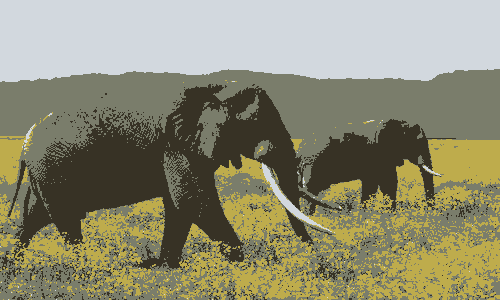

In [21]:
# code for Task 3 - one line will do
colorview(RGB, reshape(m[:,a], 3,300,500))

We now wonder how much the silhouette coefficient would be, but we need to address some sizing problem. We have 300x500=150000 pixels, to calculate the pairwise distance matrix, we need a massive memorty space for 22.5G float values! We have to downsize our data first, a simple trick here is to just use every 10th pixel:  

In [22]:
pixarr2 = pixarr[:, 1:10:end]

3×15000 Array{N0f8,2} with eltype N0f8:
 0.851  0.882  0.804  0.863  0.796  …  0.694  0.737  0.824  0.608  0.361
 0.871  0.902  0.82   0.882  0.824     0.627  0.686  0.804  0.569  0.388
 0.882  0.914  0.855  0.894  0.855     0.314  0.247  0.31   0.298  0.224

**Task 4**. Use the downsize pixel array to generate pairwise distance matrix and use it to evaluate clustering carried out with k ranged between 2 and 10. Generate a run chart of average silhouette coefficients vs k. 

In [23]:
using Distances, Statistics
dists = pairwise(SqEuclidean(), pixarr2)

15000×15000 Matrix{Float32}:
 0.0         0.00784306  0.0117645   …  0.333333   0.494117    0.913725
 0.00784306  0.0         0.0117646      0.380392   0.564706    1.01569
 0.0117645   0.0117646   0.0            0.290196   0.403922    0.776471
 0.00784341  0.00784306  0.0117645      0.349019   0.517647    0.952941
 0.00784292  0.0235296   0.00392145     0.294118   0.415686    0.772549
 0.0117644   0.0117645   0.0         …  0.313725   0.435294    0.815686
 0.0117646   0.0196077   0.0            0.298039   0.396078    0.760784
 0.0392156   0.0705885   0.0117643      0.247059   0.290196    0.592157
 0.129411    0.168627    0.0784312      0.25098    0.2         0.4
 0.352941    0.415686    0.270588       0.333333   0.141176    0.192157
 0.376471    0.439216    0.286275    …  0.333333   0.141176    0.176471
 0.388235    0.458823    0.298039       0.337255   0.137255    0.164706
 0.356863    0.427451    0.27451        0.313726   0.121569    0.172549
 ⋮                                   ⋱   

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.793511e+03
      1       1.326537e+03      -4.669739e+02 |        2
      2       1.322044e+03      -4.493164e+00 |        2
      3       1.318567e+03      -3.477295e+00 |        2
      4       1.315055e+03      -3.511475e+00 |        2
      5       1.306398e+03      -8.657593e+00 |        2
      6       1.285233e+03      -2.116492e+01 |        2
      7       1.256611e+03      -2.862183e+01 |        2
      8       1.241504e+03      -1.510681e+01 |        2
      9       1.235139e+03      -6.364868e+00 |        2
     10       1.232344e+03      -2.795288e+00 |        2
     11       1.230851e+03      -1.493286e+00 |        2
     12       1.229699e+03      -1.151978e+00 |        2
     13       1.228865e+03      -8.343506e-01 |        2
     14       1.228328e+03      -5.366211e-01 |        2
     15       1.228036e+03      -2.922363e-01 |        

┌ Warning: The clustering cost increased at iteration #12
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.686056e+02
      1       3.746261e+02      -9.397946e+01 |        4
      2       3.667552e+02      -7.870941e+00 |        4
      3       3.644669e+02      -2.288300e+00 |        4
      4       3.638168e+02      -6.500244e-01 |        4
      5       3.636148e+02      -2.020569e-01 |        4
      6       3.635796e+02      -3.521729e-02 |        4
      7       3.635680e+02      -1.159668e-02 |        3
      8       3.635629e+02      -5.035400e-03 |        3
      9       3.635631e+02       1.525879e-04 |        0
     10       3.635631e+02       0.000000e+00 |        0
K-means converged with 10 iterations (objv = 363.56308)


┌ Warning: The clustering cost increased at iteration #9
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.526760e+02
      1       3.306416e+02      -1.220345e+02 |        5
      2       2.873403e+02      -4.330130e+01 |        5
      3       2.376737e+02      -4.966653e+01 |        5
      4       2.297007e+02      -7.973022e+00 |        5
      5       2.276903e+02      -2.010437e+00 |        5
      6       2.272135e+02      -4.767761e-01 |        5
      7       2.271377e+02      -7.577515e-02 |        4
      8       2.271235e+02      -1.425171e-02 |        4
      9       2.271194e+02      -4.089355e-03 |        4
     10       2.271204e+02       1.052856e-03 |        4
     11       2.271180e+02      -2.410889e-03 |        3
     12       2.271136e+02      -4.440308e-03 |        2
     13       2.271144e+02       8.239746e-04 |        2
     14       2.271146e+02       1.678467e-04 |        2
     15       2.271150e+02       4.119873e-04 |        

┌ Warning: The clustering cost increased at iteration #10
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #13
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #14
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #15
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191



  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.796229e+02
      1       2.758046e+02      -1.038183e+02 |        6
      2       2.385174e+02      -3.728717e+01 |        6
      3       2.165620e+02      -2.195541e+01 |        6
      4       2.065124e+02      -1.004958e+01 |        6
      5       2.019690e+02      -4.543381e+00 |        6
      6       1.999128e+02      -2.056213e+00 |        6
      7       1.987434e+02      -1.169434e+00 |        5
      8       1.982047e+02      -5.386658e-01 |        4
      9       1.979114e+02      -2.932739e-01 |        4
     10       1.977125e+02      -1.989288e-01 |        4
     11       1.976134e+02      -9.910583e-02 |        4
     12       1.975500e+02      -6.341553e-02 |        4
     13       1.975135e+02      -3.649902e-02 |        4
     14       1.975066e+02      -6.896973e-03 |        3
     15       1.975054e+02      -1.190186e-03 |       

┌ Warning: The clustering cost increased at iteration #19
└ @ Clustering C:\Users\kapil\.julia\packages\Clustering\yuxBr\src\kmeans.jl:191


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.782495e+02
      1       1.702218e+02      -1.080277e+02 |        8
      2       1.576752e+02      -1.254662e+01 |        8
      3       1.520618e+02      -5.613419e+00 |        8
      4       1.480409e+02      -4.020935e+00 |        8
      5       1.453629e+02      -2.677963e+00 |        8
      6       1.434771e+02      -1.885757e+00 |        8
      7       1.419750e+02      -1.502151e+00 |        6
      8       1.407998e+02      -1.175186e+00 |        6
      9       1.398995e+02      -9.002838e-01 |        6
     10       1.390554e+02      -8.441010e-01 |        6
     11       1.383271e+02      -7.282715e-01 |        7
     12       1.376359e+02      -6.912537e-01 |        8
     13       1.367889e+02      -8.469543e-01 |        8
     14       1.357611e+02      -1.027863e+00 |        8
     15       1.347865e+02      -9.745789e-01 |        

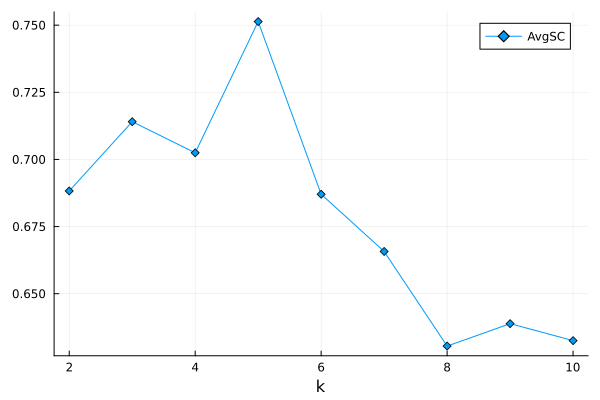

In [24]:
scs = []

for k in 2:10
    km = kmeans(pixarr2, k; maxiter=20, display=:iter)
    m = assignments(km)
    c = counts(km)
    push!(scs, mean(silhouettes(m, dists)))
end
plot(2:10, scs, label="AvgSC", xlabel="k", marker=:d)